In [88]:
import requests

from bs4 import BeautifulSoup

import pandas as pd



# Web Scraping


In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records"

response = requests.get(url, headers={"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"})

response.raise_for_status()

In [7]:
response

<Response [200]>

In [23]:
soup = BeautifulSoup(response.content, 'html.parser')
soup

<!DOCTYPE html>

<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of Spotify streaming records - Wikipedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-conten

In [46]:
table = soup.find("table", class_="wikitable sortable plainrowheaders")


In [62]:
encabezados = []

for th in table.find_all("th")[0:5]:
    encabezados.append(th.get_text().strip())


In [65]:
encabezados

['Rank', 'Song', 'Artist(s)', 'Streams(billions)', 'Release date']

In [ ]:
table.find_all("tr")[1:][0].find_all(['td','th'])[0:5].text.strip()

[<td style="text-align:center;">1
 </td>,
 <th scope="row">"<a href="/wiki/Blinding_Lights" title="Blinding Lights">Blinding Lights</a>"
 </th>,
 <td style="text-align:left;"><a href="/wiki/The_Weeknd" title="The Weeknd">The Weeknd</a></td>,
 <td style="text-align:center;">5.221</td>,
 <td style="text-align:right;"><span data-sort-value="000000002019-11-29-0000" style="white-space:nowrap">29 November 2019</span></td>]

In [86]:
filas = []

for tr in table.find_all('tr')[1:101]:
    celdas = tr.find_all(['td', 'th'])[0:5]
    info_fila = [celda.getText().strip() for celda in celdas]
    if info_fila:
        filas.append(info_fila)

In [84]:
df = pd.DataFrame(filas, columns=encabezados)
df["Streams(billions)"] = df["Streams(billions)"].astype('float')
df["Release date"] = pd.to_datetime(df["Release date"], errors="coerce")

# Cargue de Información a Base de Datos SQL

In [92]:
import sqlite3

conn = sqlite3.connect("../data/web_db.db")

In [93]:
df.to_sql("spotify", conn, if_exists='replace' ,index=False)
cursor = conn.cursor

In [98]:
pd.read_sql_query(" SELECT Song FROM spotify WHERE [Artist(s)] = 'Ed Sheeran' AND [Streams(billions)] > 4", conn)

,Song
0,"""Shape of You"""


# Visualización

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Si YA tienes df en memoria, comenta este bloque.
# Si quieres cargar desde tu SQLite:
import sqlite3
conn = sqlite3.connect("../data/web_db.db")
df = pd.read_sql_query("SELECT * FROM spotify", conn)

# Limpieza/tipos (por si acaso)
df = df.copy()
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")
df["Streams(billions)"] = pd.to_numeric(df["Streams(billions)"], errors="coerce")
df["Release date"] = pd.to_datetime(df["Release date"], errors="coerce")
df["release_year"] = df["Release date"].dt.year

df = df.sort_values("Rank")
df.head()

,Rank,Song,Artist(s),Streams(billions),Release date,release_year
0,1,"""Blinding Lights""",The Weeknd,5.221,2019-11-29,2019
1,2,"""Shape of You""",Ed Sheeran,4.716,2017-01-06,2017
2,3,"""Starboy""",The Weeknd and Daft Punk,4.295,2016-09-21,2016
3,4,"""Sweater Weather""",The Neighbourhood,4.294,2012-12-03,2012
4,5,"""As It Was""",Harry Styles,4.186,2022-04-01,2022


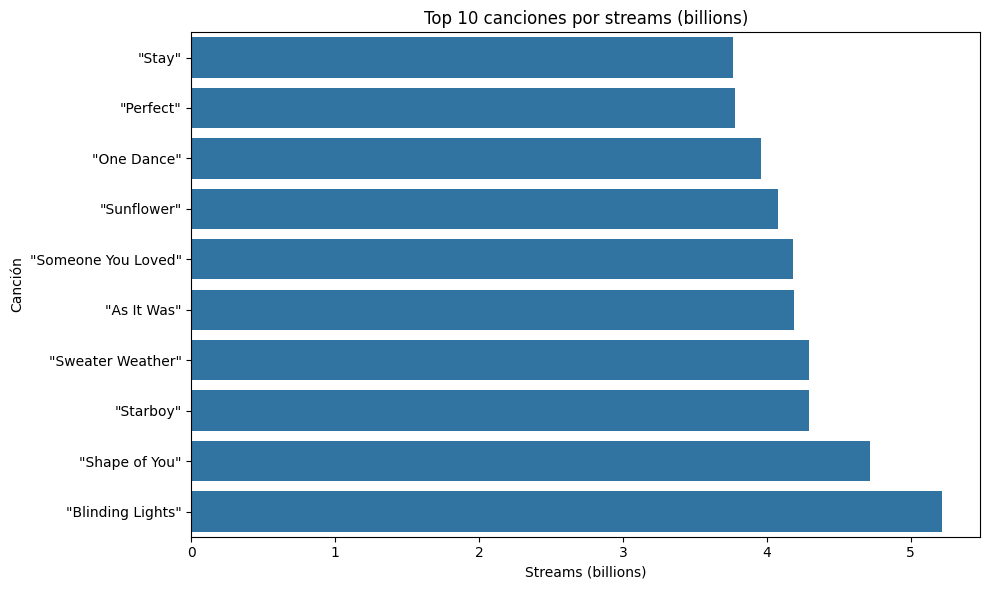

In [100]:
top10 = df.dropna(subset=["Streams(billions)"]).nlargest(10, "Streams(billions)")
top10 = top10.sort_values("Streams(billions)")

plt.figure(figsize=(10, 6))
sns.barplot(data=top10, x="Streams(billions)", y="Song")
plt.title("Top 10 canciones por streams (billions)")
plt.xlabel("Streams (billions)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()

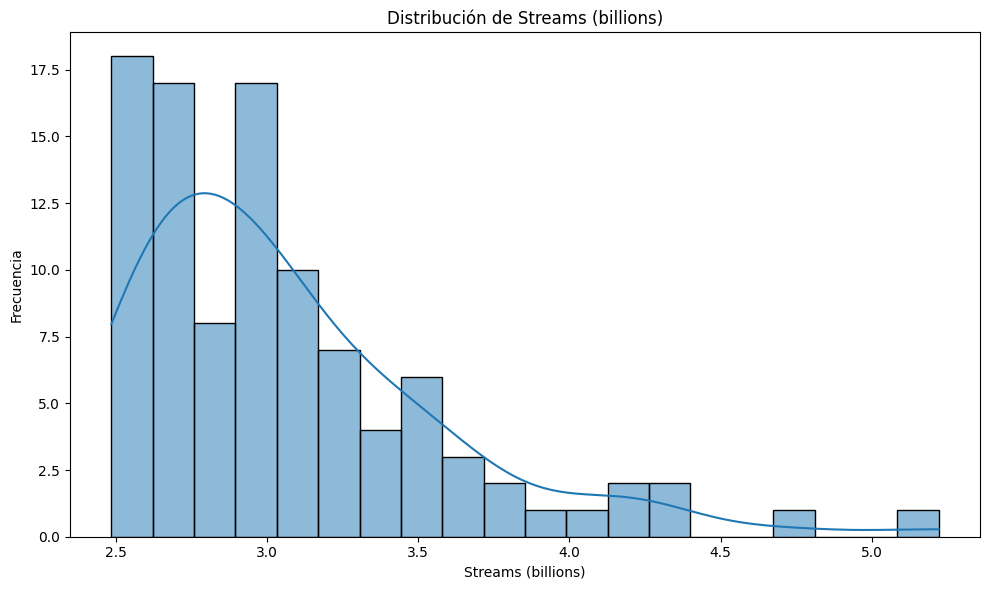

In [101]:
plt.figure(figsize=(10, 6))
sns.histplot(df["Streams(billions)"].dropna(), bins=20, kde=True)
plt.title("Distribución de Streams (billions)")
plt.xlabel("Streams (billions)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

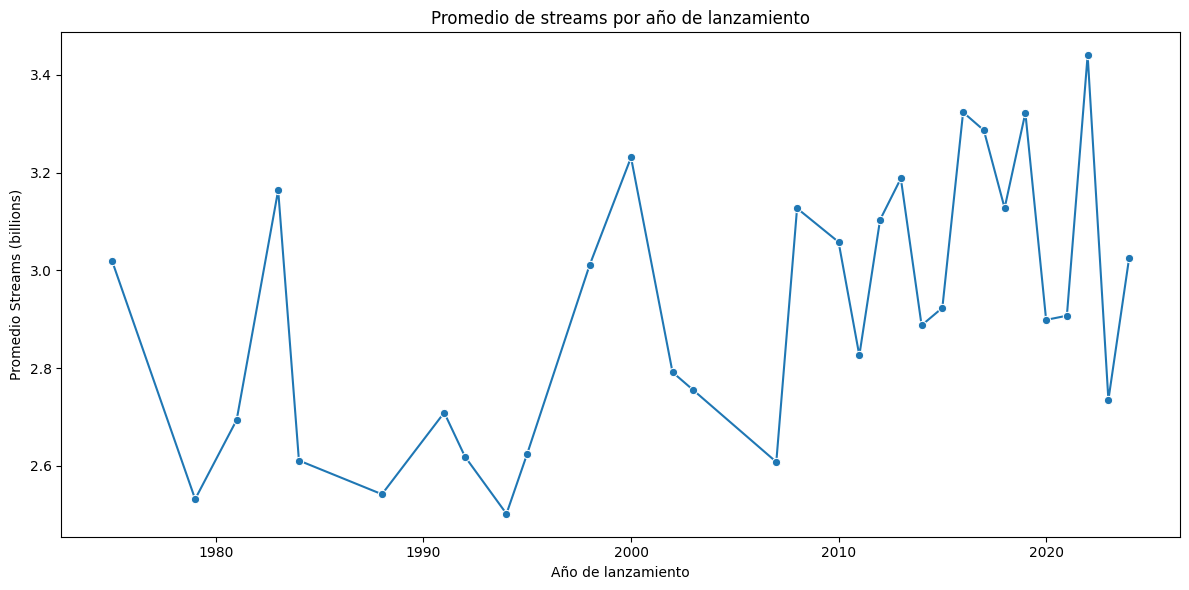

In [102]:
by_year = (
    df.dropna(subset=["release_year", "Streams(billions)"])
      .groupby("release_year", as_index=False)["Streams(billions)"]
      .mean()
      .sort_values("release_year")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=by_year, x="release_year", y="Streams(billions)", marker="o")
plt.title("Promedio de streams por año de lanzamiento")
plt.xlabel("Año de lanzamiento")
plt.ylabel("Promedio Streams (billions)")
plt.tight_layout()
plt.show()
